### Scatter plot for evaluating FLC estimation performance

* data in  `FLCI_scatter_plot_data` generated in `FLCI.ipynb` and `satellite_image.ipynb`

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature

In [2]:
data_dir = 'FLCI_scatter_plot_data/'
flc_est_file = 'btd_georgesbank_20240620.nc'
sat_btd_file = 'satellite_2024_06_20_06Z.nc'

flc_est = xr.open_dataset(data_dir+flc_est_file)
sat_btd = xr.open_dataset(data_dir+sat_btd_file)

In [3]:

#--- Satellite BTD data
lat2d = sat_btd['lat'].values
lon2d = sat_btd['lon'].values
lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()

#--- FLC estimation data
lat_vals = flc_est['latitude'].values
lon_vals = flc_est['longitude'].values-360

results = []
yx_pairs = np.indices(lat2d.shape).reshape(2, -1).T

#--- For each FLC estimation point, find nearest satellite data point
for lat in lat_vals.ravel():
    for lon in lon_vals.ravel(): 
        
        #--- Distance to each satellite data point
        dists = np.sqrt((lat_flat - lat)**2 + (lon_flat - lon)**2)
        min_idx = np.argmin(dists)
        y_idx, x_idx = yx_pairs[min_idx]

        #--- Extract value at the nearest point
        value = sat_btd['__xarray_dataarray_variable__'].isel(y=y_idx, x=x_idx).values.item()

        results.append({'lat': lat, 'lon': lon, 'nearest_value': value})

df_results = pd.DataFrame(results)


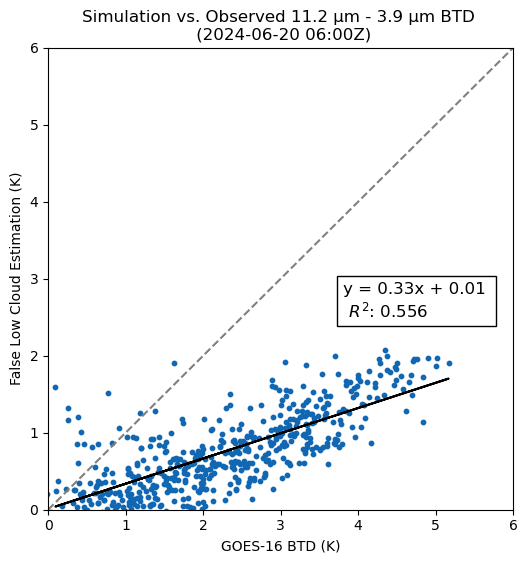

In [4]:
plt.figure(figsize=(6, 6))
low_lim = 0
high_lim = 6
plt.xlim(low_lim, high_lim)
plt.ylim(low_lim, high_lim)

#--- X is satellite BTD, y is FLC estimation
x = df_results.nearest_value
y = flc_est.BTD.values.ravel()

#--- Removing nan values (land surfaces in BTD)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

plt.scatter(x, y, color='#1167b1', marker='o', s=10)

#--- Ideal x=y line
plt.plot([low_lim, high_lim], [low_lim, high_lim], color='grey', linestyle='--')

#--- Best fit line
mask = (x >= low_lim) & (x <= high_lim) & (y >= low_lim) & (y <= high_lim)
x_filtered = x[mask]
y_filtered = y[mask]
slope, intercept = np.polyfit(x_filtered, y_filtered, 1)
y_fit = slope * x_filtered + intercept
#------ R² calculation
ss_res = np.sum((y_filtered - y_fit) ** 2)              # Residual sum of squares
ss_tot = np.sum((y_filtered - np.mean(y_filtered)) ** 2)         # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)              # R² formula
plt.plot(x_filtered, y_fit, color='black')

# Display R²
plt.text(3.8, 2.5, 
         f'y = {slope:.2f}x + {intercept:.2f} \n $R^2$: {r_squared:.3f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Simulation vs. Observed 11.2 μm - 3.9 μm BTD \n (2024-06-20 06:00Z)")
plt.xlabel("GOES-16 BTD (K)")
plt.ylabel("False Low Cloud Estimation (K)")

plt.savefig(data_dir+'/scatter_plot.png', dpi=300)
plt.show()

### Estimation of FLCI accuracy

In [5]:
sat_data = df_results
flc_data = flc_est


In [6]:
print(f'satellite data: {np.shape(sat_data.nearest_value)}, FLC data: {np.shape(flc_data.BTD.values.ravel())}')

satellite data: (3445,), FLC data: (3445,)


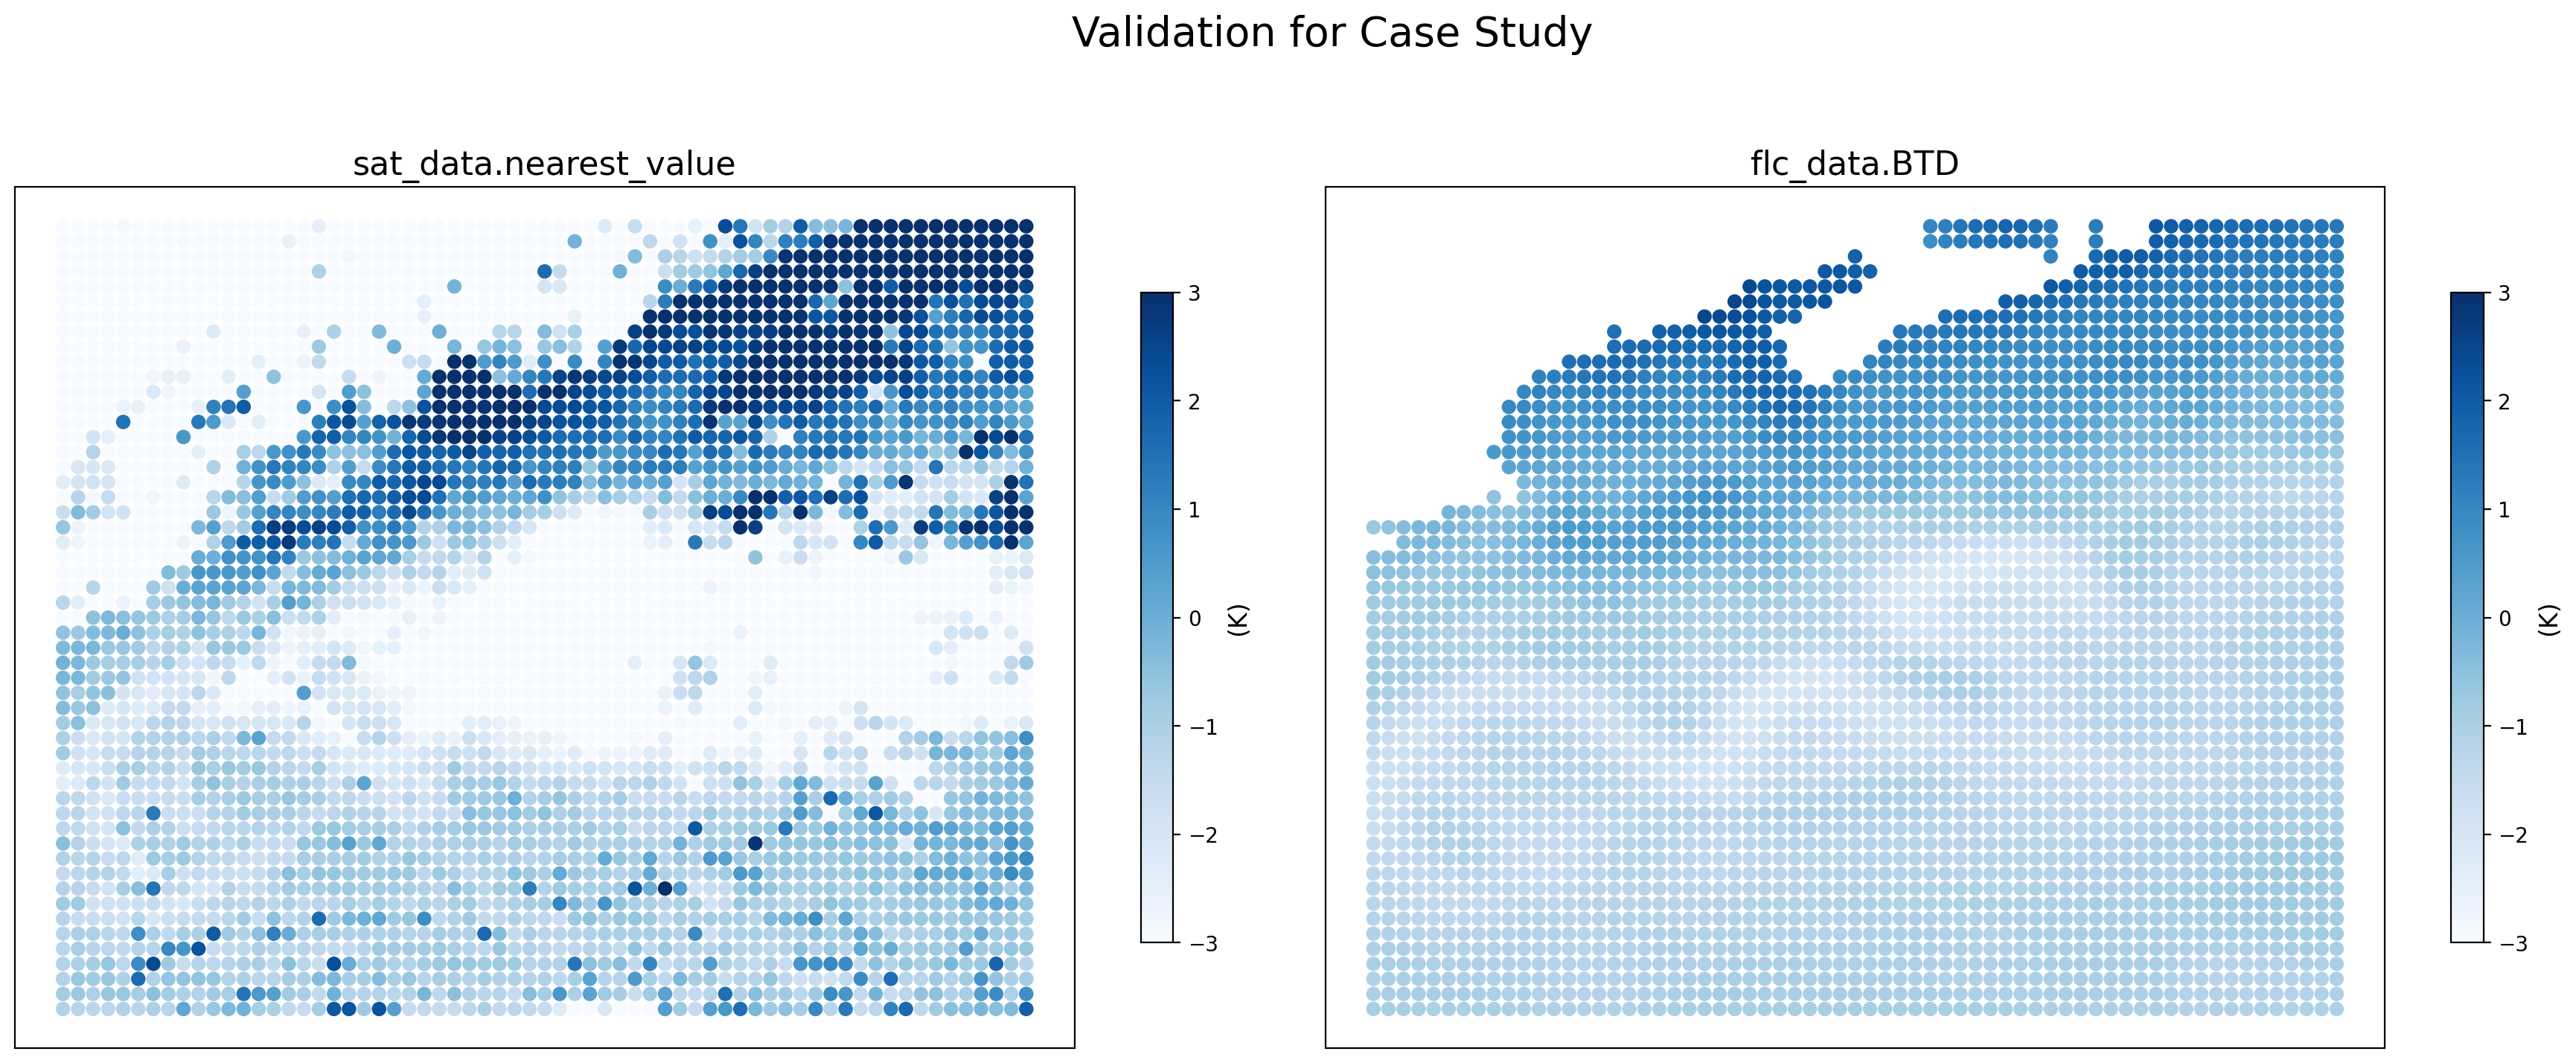

In [7]:
projection = ccrs.PlateCarree(central_longitude=0)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': projection})

# First plot: sat_data.nearest_value
sc1 = axes[0].scatter(
    sat_data.lon, sat_data.lat,
    c=sat_data.nearest_value, cmap='Blues', vmin=-3, vmax=3
)
cb1 = plt.colorbar(sc1, ax=axes[0], shrink=0.6, pad=0.05)
cb1.set_label('(K)', fontsize=12)
axes[0].set_title("sat_data.nearest_value", fontsize=16)

# Second plot: flc_data.BTD.values
sc2 = axes[1].scatter(
    sat_data.lon, sat_data.lat,
    c=flc_data.BTD.values.ravel(), cmap='Blues', vmin=-3, vmax=3
)
cb2 = plt.colorbar(sc2, ax=axes[1], shrink=0.6, pad=0.05)
cb2.set_label('(K)', fontsize=12)
axes[1].set_title("flc_data.BTD", fontsize=16)

fig.suptitle("Validation for Case Study", fontsize=20)
fig.set_dpi(200)
plt.tight_layout()
plt.show()


In [14]:
valid = sat_data.nearest_value - flc_data.BTD.values.ravel()

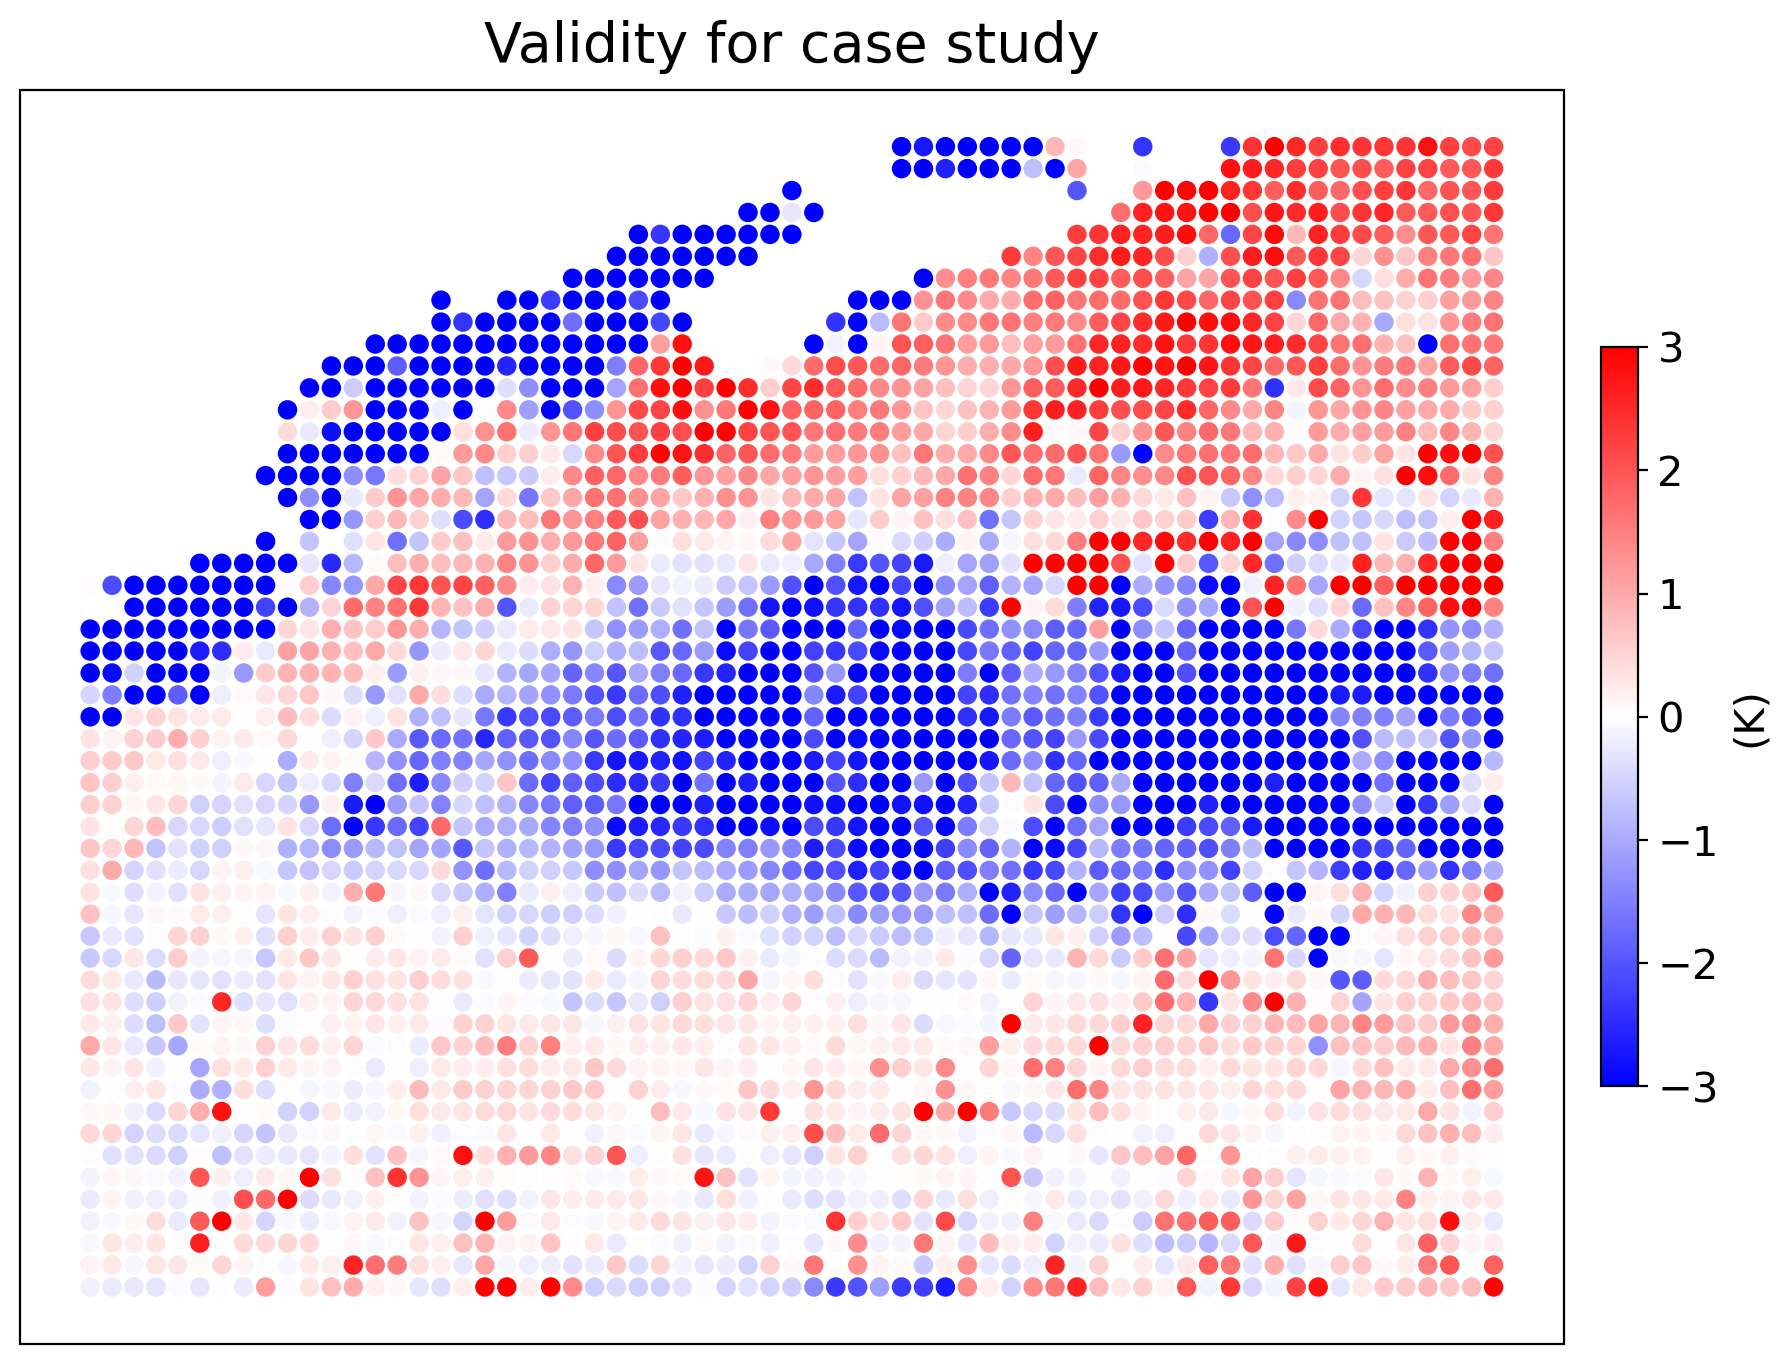

In [15]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

c=ax.scatter(sat_data.lon, sat_data.lat, c=valid, cmap='bwr', vmax=3, vmin=-3)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

ax.set_title("Validity for case study", fontsize=20, pad=10)

fig.set_dpi(200)
plt.show()

* FLC > 0 and Clear cloud mask in DNB and ABI BTD > 0 --> correctly identified FLC
* FLC < 0 and Clear cloud mask in DNB and ABI BTD > 0 --> missed FLC
* FLC > 0 and Clear cloud mask in DNB and ABI BTD < 0 --> overstated FLC

**Need to apply a custom cloud mask based on DNB before this step**

In [ ]:
sat_arr = np.array(sat_data.nearest_value)
flc_arr = np.array(flc_data.BTD.values.ravel())

# Remove pairs where either value is NaN
valid_mask = ~np.isnan(sat_arr) & ~np.isnan(flc_arr)
sat_arr_clean = sat_arr[valid_mask]
flc_arr_clean = flc_arr[valid_mask]

correct_flc = (sat_arr_clean > 0) & (flc_arr_clean > 0)
missed_flc = (sat_arr_clean > 0) & (flc_arr_clean < 0)
overstated_no_cloud = (sat_arr_clean < 0) & (flc_arr_clean > 0)
correct_no_cloud = (sat_arr_clean < 0) & (flc_arr_clean < 0)

total = len(sat_arr_clean)

print(f"Correct FLC: {(100 * np.sum(correct_flc) / total):.2f}%")
print(f"Missed FLC: {(100 * np.sum(missed_flc) / total):.2f}%")
print(f"Overstated No Cloud: {(100 * np.sum(overstated_no_cloud) / total):.2f}%")
print(f"Correct No Cloud: {(100 * np.sum(correct_no_cloud) / total):.2f}%")


Correct FLC: 16.98%
Missed FLC: 9.27%
Overstated No Cloud: 5.65%
Correct No Cloud: 68.11%
